In [1]:
import pandas as pd
import numpy as np
import os 

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, cross_val_predict

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from geopy.geocoders import Nominatim
import warnings 
warnings.simplefilter('ignore')

#### 1. Load our data and perform any basic cleaning and/or EDA.

In [2]:
station_names = ['Aberporth', 'Armagh', 'Ballypatrick Forest', 'Bradford', 'Braemar', 'Camborne', 'Cambridge NIAB', 'Cardiff Bute Park',
 'Chivenor', 'Cwmystwyth', 'Dunstaffnage', 'Durham', 'Eastbourne', 'Eskdalemuir', 'Heathrow', 'Hurn', 'Lerwick',
 'Leuchars', 'Lowestoft', 'Manston', 'Nairn', 'Newton Rigg', 'Oxford', 'Paisley', 'Ringway', 'Ross-on-Wye',
 'Shawbury', 'Sheffield', 'Southampton', 'Stornoway Airport', 'Sutton Bonington', 'Tiree', 'Valley',
 'Waddington', 'Whitby', 'Wick Airport', 'Yeovilton']

In [3]:
lower_station_names = []
for i in station_names:
    lower_station_names.append(i.lower().replace(' ','_').replace('-','_'))

In [4]:
def data_clean(station_name):
    station_name = pd.read_excel('/Users/paxton615/Github_Personal/Notes/Notes/Weather_stations/Weather_stations/{}.xlsx'.format(station_name))
    
    station_name = station_name.iloc[1:,:-1] # get rid of useless row and column, 去除多余行，列
    # 这里有一个例外 Yeovilton 需要 station_name.iloc[1:,:] 这样slice 
    
    col_names = ['year', 'month', 'tmax', 'tmin', 'af', 'rain', 'sun',
            'station', 'lat', 'lon'] # temperatre units: degC, rainfall units: mm, sun units: days
    station_name.columns = col_names # replace column names with col_names, 替换列名成 col_names
    
    # fill in station, lat and lon with its value, 给车站，经纬度填上唯一值
    station_name['station']= station_name.iloc[0, 7].lower().replace('-', '_').replace(' ','_')
    station_name['lat'] = station_name.iloc[0,8]
    station_name['lon'] = station_name.iloc[0,9]
    
    # replace --- with 0
    station_name = station_name.replace('---', 0)
    station_name = station_name.replace('--- #', 0)

    # fillna with 0s, 将所有NaN替换成 0
    station_name.fillna(0, inplace=True)
    
    # tidy all entries and unify types, 消除非数字字符，改type
    
    station_name['sun'] = station_name['sun'].astype(str)
    station_name['sun'] = station_name['sun'].str.extract(r'(\d+.\d+)').astype('float')

    station_name['tmax'] = station_name['tmax'].astype(str)
    station_name['tmax'] = station_name['tmax'].str.extract(r'(-?\d+.\d+)').astype('float')

    station_name['tmin'] = station_name['tmin'].astype(str)
    station_name['tmin'] = station_name['tmin'].str.extract(r'(-?\d+.\d+)').astype('float')

    station_name['rain'] = station_name['rain'].astype(str)
    station_name['rain'] = station_name['rain'].str.extract(r'(\d+.\d+)').astype('float')

    station_name['af'] = station_name['af'].astype(str)
    station_name['af'] = station_name['af'].str.extract(r'(\d+)').astype('float')

    
    # fillna with 0s, 将所有NaN替换成 0
    station_name = station_name.fillna(0)
    
    return station_name

In [5]:
#  found one exception data: Yeovilton, the slice of this data is different to all others

def yeovilton_clean(station_name):
    station_name = pd.read_excel('/Users/paxton615/Github_Personal/Notes/Notes/Weather_stations/Weather_stations/{}.xlsx'.format(station_name))
    
    station_name = station_name.iloc[1:,:] # get rid of useless row and column, 去除多余行，列
    # 这里有一个例外 Yeovilton 需要 station_name.iloc[1:,:] 这样slice 
    
    col_names = ['year', 'month', 'tmax', 'tmin', 'af', 'rain', 'sun',
            'station', 'lat', 'lon'] # temperatre units: degC, rainfall units: mm, sun units: days
    station_name.columns = col_names # replace column names with col_names, 替换列名成 col_names
    
    # fill in station, lat and lon with its value, 给车站，经纬度填上唯一值
    station_name['station']= station_name.iloc[0, 7].lower().replace('-', '_').replace(' ','_')
    station_name['lat'] = station_name.iloc[0,8]
    station_name['lon'] = station_name.iloc[0,9]
    
    # replace --- with 0
    station_name = station_name.replace('---', 0)
    station_name = station_name.replace('--- #', 0)

    # fillna with 0s, 将所有NaN替换成 0
    station_name.fillna(0, inplace=True)
    
    # tidy all entries and unify types, 消除非数字字符，改type
    
    station_name['sun'] = station_name['sun'].astype(str)
    station_name['sun'] = station_name['sun'].str.extract(r'(\d+.\d+)').astype('float')

    station_name['tmax'] = station_name['tmax'].astype(str)
    station_name['tmax'] = station_name['tmax'].str.extract(r'(-?\d+.\d+)').astype('float')

    station_name['tmin'] = station_name['tmin'].astype(str)
    station_name['tmin'] = station_name['tmin'].str.extract(r'(-?\d+.\d+)').astype('float')

    station_name['rain'] = station_name['rain'].astype(str)
    station_name['rain'] = station_name['rain'].str.extract(r'(\d+.\d+)').astype('float')

    station_name['af'] = station_name['af'].astype(str)
    station_name['af'] = station_name['af'].str.extract(r'(\d+)').astype('float')

    
    # fillna with 0s, 将所有NaN替换成 0
    station_name = station_name.fillna(0)
    
    return station_name

In [6]:
aberporth = data_clean('Aberporth')
armagh = data_clean('Armagh')
ballypatrick_forest= data_clean('Ballypatrick Forest')
bradford = data_clean('Bradford')
braemar = data_clean('Braemar')
camborne = data_clean('Camborne')
cambridge_niab = data_clean('Cambridge NIAB')
cardiff_bute_park = data_clean('Cardiff Bute Park')
chivenor = data_clean('Chivenor')
cwmystwyth = data_clean('Cwmystwyth')
dunstaffnage = data_clean('Dunstaffnage')
durham = data_clean('Durham')
eastbourne = data_clean('Eastbourne')
eskdalemuir = data_clean('Eskdalemuir')
heathrow = data_clean('Heathrow')
hurn = data_clean('Hurn')
lerwick = data_clean('Lerwick')
leuchars = data_clean('Leuchars')
lowestoft = data_clean('Lowestoft')
manston = data_clean('Manston')
nairn = data_clean('Nairn')
newton_rigg = data_clean('Newton Rigg')
oxford = data_clean('Oxford')
paisley = data_clean('Paisley')
ringway = data_clean('Ringway') # last year is 2004, not 2022
ross_on_wye = data_clean('Ross-on-Wye')
shawbury = data_clean('Shawbury')
sheffield = data_clean('Sheffield')
southampton = data_clean('Southampton') # last year 2000,not 2022
stornoway_airport = data_clean('Stornoway')
sutton_bonington = data_clean('Sutton Bonington')
tiree = data_clean('Tiree')
valley = data_clean('Valley')
waddington = data_clean('Waddington')
whitby = data_clean('Whitby')
wick_airport = data_clean('Wick Airport')
yeovilton = yeovilton_clean('Yeovilton') 
# for some reason, yeovilton needs function to be altered as such:
# station_name = station_name.iloc[1:,:]

In [7]:
# check the last year and month of all stations

In [8]:
uni = [aberporth, armagh, ballypatrick_forest, bradford, braemar,
      camborne, cambridge_niab, cardiff_bute_park, chivenor, 
      cwmystwyth, dunstaffnage, durham, eastbourne, eskdalemuir,
      heathrow, hurn, lerwick, leuchars, lowestoft, manston,
      nairn, newton_rigg, oxford, paisley, ringway, ross_on_wye,
      shawbury, sheffield, southampton, stornoway_airport, 
      sutton_bonington, tiree, valley, waddington, whitby,
      wick_airport, yeovilton]
len(uni)

37

In [9]:
# YEAR
# for i in uni:
#     print('{}          year:{}'.format(i.iloc[-1,7],i.iloc[-1,0]))

In [10]:
# cwmystwyth          year:2011.0  (other data's year all end at 2022)
# ringway             year:2004.0  (other data's year all end at 2022)
# southampton         year:2000.0  (other data's year all end at 2022)

In [11]:
# MONTH
# for i in uni:
#     print('{}          month:{}'.format(i.iloc[-1,7],i.iloc[-1,1]))

In [12]:
# ringway            month:10.0   (other data's month all end at March)
    

# PART 1

#### There are missing data and errors. For example, the highest temperature is 0. 
#### So, I decide to do some data engineering and to use average temperature, fog, rain and sun instead of the originals.

In [13]:
uni[36].tail(3)

,year,month,tmax,tmin,af,rain,sun,station,lat,lon
689,2022.0,1.0,0.0,0.5,15.0,22.4,62.7,yeovilton,51.006,-2.641
690,2022.0,2.0,11.2,3.8,4.0,41.8,72.2,yeovilton,51.006,-2.641
691,2022.0,3.0,13.1,3.5,5.0,49.2,164.7,yeovilton,51.006,-2.641


In [14]:
pd.DataFrame({"station":uni[36].iloc[-1,7],
#               'all_tmx':uni[36].iloc[:,2].max(),   #all_  means the highest temperature
#              'all_tmin':uni[36].iloc[:,3].min(), 
             'avg_tmx':np.round(uni[36].iloc[:,2].mean(),2), 
             'avg_tmin':np.round(uni[36].iloc[:,3].mean(),2),
              'avg_af':np.round(uni[36].iloc[:,4].mean(),2),
              'avg_rain':np.round(uni[36].iloc[:,5].mean(),2),
              'avg_sun':np.round(uni[36].iloc[:,6].mean(),2),
             'lat':uni[36].iloc[-1,8],
             'lon':uni[36].iloc[-1,9]},
             index=[1]).columns

Index(['station', 'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain', 'avg_sun',
       'lat', 'lon'],
      dtype='object')

In [15]:
vase = []
for i in uni:
    vase.append([i.iloc[-1,7],
              np.round(i.iloc[:,2].mean(),2),
               np.round(i.iloc[:,3].mean(),2),
               np.round(i.iloc[:,4].mean(),2),
               np.round(i.iloc[:,5].mean(),2),
               np.round(uni[36].iloc[:,6].mean(),2),
             i.iloc[-1,8],
             i.iloc[-1,9]])

In [16]:
data = pd.DataFrame(vase, columns = ['station', 'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain', 'avg_sun',
       'lat', 'lon'])
data.dtypes

station      object
avg_tmx     float64
avg_tmin    float64
avg_af      float64
avg_rain    float64
avg_sun     float64
lat         float64
lon         float64
dtype: object

In [17]:
data.head()

,station,avg_tmx,avg_tmin,avg_af,avg_rain,avg_sun,lat,lon
0,aberporth,12.23,7.14,1.22,76.26,83.26,52.139,-4.570
1,armagh,10.79,4.71,3.05,63.51,83.26,54.352,-6.649
2,ballypatrick_forest,10.88,5.28,2.33,60.04,83.26,55.181,-6.153
3,bradford,11.09,5.16,3.72,66.01,83.26,53.813,-1.772
4,braemar,9.23,2.43,8.64,66.70,83.26,57.006,-3.396


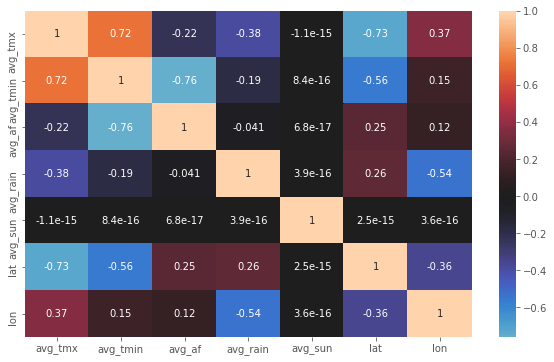

In [18]:
corrmat= data.corr()
plt.figure(figsize=(10,6))  
sns.heatmap(corrmat,annot=True,  center=0);

#### Set up an X matrix to perform clustering with DBSCAN.

In [19]:
# ['station', 'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain', 'avg_sun','lat', 'lon']

In [20]:
X = data.drop(['station','avg_sun'], axis = 1) # Because the number in 'avg_sun' are all the same.
X.head(2)

,avg_tmx,avg_tmin,avg_af,avg_rain,lat,lon
0,12.23,7.14,1.22,76.26,52.139,-4.570
1,10.79,4.71,3.05,63.51,54.352,-6.649


#### visualize data

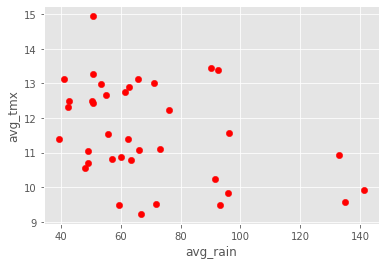

In [21]:
X.plot(x='avg_rain', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

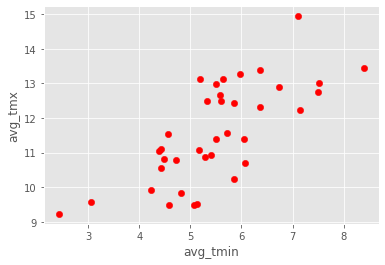

In [22]:
X.plot(x='avg_tmin', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

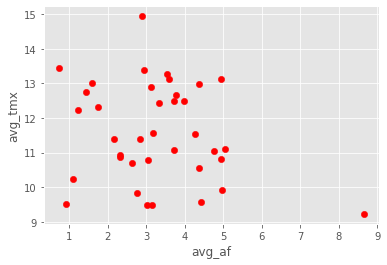

In [23]:
X.plot(x='avg_af', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

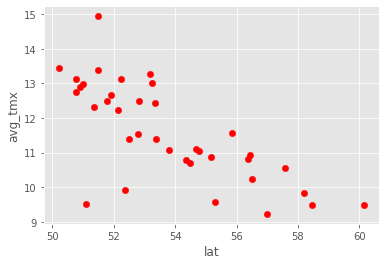

In [24]:
X.plot(x='lat', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

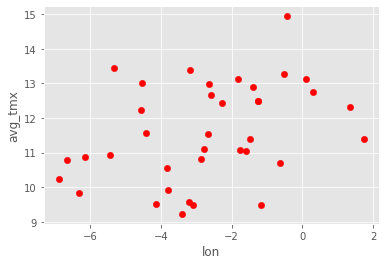

In [25]:
X.plot(x='lon', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

#### Scale data

In [26]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

#### Fit a DBSCAN clusterer and check out the assigned cluster labels

In [27]:
dbscan = DBSCAN(eps=1, min_samples=2)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[ 0  1  1  2 -1 -1  3 -1 -1 -1 -1  4 -1 -1 -1  3 -1  4  5  5  4  4  3 -1
  3  3  2  2 -1 -1  3 -1  0  3 -1 -1  3] 

types of clusters: 6


In [28]:
dbscan = DBSCAN(eps=1.5, min_samples=3)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[-1 -1 -1  0 -1 -1  0 -1 -1 -1 -1  0  1 -1 -1  0 -1  0  1  1  0  0  0 -1
  0  0  0  0  0 -1  0 -1 -1  0  0  0  0] 

types of clusters: 2


##### I noticed that if min_samples is bigger than 2, there are many unlabeled ones in the results. Gradually tuning my model.

In [29]:
dbscan = DBSCAN(eps=1.9, min_samples=2)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[ 0  1  1  0 -1  0  0  0 -1  2  1  0  0  2  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  1  0  1  0  0  0  0  0] 

types of clusters: 3


##### With eps=1.9 or 2 and min_samples=2, I have got the least unlabeled ones.

In [30]:
dbscan = DBSCAN(eps=2, min_samples=2)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[ 0  1  1  0 -1  0  0  0 -1  2  1  0  0  2  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  1  0  1  0  0  0  0  0] 

types of clusters: 3


In [31]:
data['cluster_est'] = labels
data.head()

,station,avg_tmx,avg_tmin,avg_af,avg_rain,avg_sun,lat,lon,cluster_est
0,aberporth,12.23,7.14,1.22,76.26,83.26,52.139,-4.570,0
1,armagh,10.79,4.71,3.05,63.51,83.26,54.352,-6.649,1
2,ballypatrick_forest,10.88,5.28,2.33,60.04,83.26,55.181,-6.153,1
3,bradford,11.09,5.16,3.72,66.01,83.26,53.813,-1.772,0
4,braemar,9.23,2.43,8.64,66.70,83.26,57.006,-3.396,-1


#### Findings:
The cluster isn't perfect, but its working. By checking the map, I found that :
- Label 1 are stations located in north-west and northern Ireland area.
- Label 0 covers most of the points which located in the middle and south of England.
- Label 2 doesn't make a lot sense

#### Check the core samples

In [32]:
# Extract core sample indices
print(dbscan.core_sample_indices_)

[ 0  1  2  3  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36]


In [33]:
core_samples = np.zeros_like(labels, dtype=bool)

core_samples[dbscan.core_sample_indices_] = True
core_samples

array([ True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [34]:
print("Core samples")
print((core_samples * 1))

Core samples
[1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


#### use Kmeans on data again and compare the results with DBSCAN

In [35]:
model = KMeans(n_clusters=3, random_state=0)
model.fit(Xs)

KMeans(n_clusters=3, random_state=0)

In [36]:
cluster_labels = model.labels_
print("Assigned cluster labels: \n", cluster_labels)

Assigned cluster labels: 
 [0 2 2 0 1 0 0 0 2 2 2 1 0 2 0 0 1 1 0 0 1 1 0 2 0 0 0 0 0 2 0 2 0 0 0 1 0]


In [37]:
# [ 0  1  1  0 -1  0  0  0 -1  2  1  0  0  2  0  0  0  0  0  0  0  0  0  1
#   0  0  0  0  0  1  0  1  0  0  0  0  0] 

In [38]:
centroids = model.cluster_centers_
print("Location of centroids: ")
print(centroids)

Location of centroids: 
[[ 0.6938712   0.56191765 -0.20389651 -0.42188772 -0.64708281  0.49692444]
 [-0.95736426 -1.05069393  1.0461838  -0.21548774  1.29411906  0.02213461]
 [-0.87441615 -0.4939348  -0.33793999  1.15200625  0.50332284 -1.17670616]]


In [39]:
Xs['clusters'] = cluster_labels
Xs.head()

,avg_tmx,avg_tmin,avg_af,avg_rain,lat,lon,clusters
0,0.461048,1.407818,-1.381906,0.273567,-0.660117,-0.868894,0
1,-0.569781,-0.664496,-0.156381,-0.226240,0.229378,-1.846070,2
2,-0.505354,-0.178397,-0.638555,-0.362266,0.562587,-1.612939,2
3,-0.355025,-0.280734,0.292309,-0.128239,0.012732,0.446229,0
4,-1.686512,-2.608888,3.587163,-0.101190,1.296129,-0.317087,1


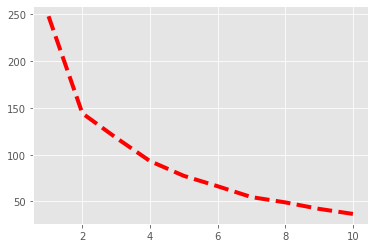

In [40]:
inertia = []
k_values = range(1, 11)
for n_clusters in k_values:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(Xs)
    inertia.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(k_values, inertia, color='r', lw=4, ls='--')
plt.show()

In [41]:
print('How many are labeled 0 by Kmeans: {}'.format(list(Xs['clusters']).count(0)))
print('How many are labeled 1 by Kmeans: {}'.format(list(Xs['clusters']).count(1)))
print('How many are labeled 2 by Kmeans: {}'.format(list(Xs['clusters']).count(2)))

How many are labeled 0 by Kmeans: 21
How many are labeled 1 by Kmeans: 7
How many are labeled 2 by Kmeans: 9


In [42]:
pd.DataFrame([data['cluster_est'],Xs['clusters']])

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
cluster_est,0,1,1,0,-1,0,0,0,-1,2,...,0,0,1,0,1,0,0,0,0,0
clusters,0,2,2,0,1,0,0,0,2,2,...,0,0,2,0,2,0,0,0,1,0


#### Findings:

Kmeans doesn't leave any points unlabeled. And by checking the results, for this data, Kmeans is working better than DBSCAN.


# PART 2

#### creating a new column, data['areas'], and divide the area by given latitudes in question. Holding back the last 5 cities as test set.

In [43]:
# lat_area: south_area(49.9 - 53.567), mid_area(53.567 - 57.233), north_area(57.233 - 60.9)
data['areas'] = [0 if  49.9<= i <= 53.567 else 1 if 53.567< i <= 57.233
                else 2 for i in data.lat ]

In [44]:
data.tail()

,station,avg_tmx,avg_tmin,avg_af,avg_rain,avg_sun,lat,lon,cluster_est,areas
32,valley,13.02,7.52,1.59,71.15,83.26,53.252,-4.535,0,0
33,waddington,13.26,5.97,3.54,50.57,83.26,53.175,-0.522,0,0
34,whitby,10.70,6.06,2.63,48.96,83.26,54.481,-0.624,0,1
35,wick_airport,9.48,4.58,3.01,59.44,83.26,58.454,-3.088,0,2
36,yeovilton,12.98,5.51,4.38,53.30,83.26,51.006,-2.641,0,0


In [45]:
baseline = list(data['areas']).count(0)/len(data['areas'])
print('The baseline is :{}'.format(baseline))

The baseline is :0.5675675675675675


In [46]:
X_train = data.iloc[:-5,1:-4]
y_train = data.iloc[:-5,-1]
X_test = data.iloc[-5:,1:-4]
y_test = data.iloc[-5:,-1]

####  Classification modeling

In [47]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
logreg = LogisticRegression (solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression()

In [49]:
print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)
# print('Logreg predicted probabilities:\n',
#       logreg.predict_proba(y_test))

Logreg intercept: [ 0.9549588   0.32806009 -1.28301889]
Logreg coef(s): [[ 0.99234511  0.44341246 -0.1116891  -0.10733032  0.        ]
 [-0.06859999 -0.40165422  0.12047447  0.16667454  0.        ]
 [-0.92374512 -0.04175825 -0.00878537 -0.05934422  0.        ]]


In [50]:
logreg.classes_

array([0, 1, 2])

In [51]:
predictions = logreg.predict(X_test)
print(predictions)
print(list(y_test))

[0 0 0 1 0]
[0, 0, 1, 2, 0]


In [52]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7500    1.0000    0.8571         3
           1     0.0000    0.0000    0.0000         1
           2     0.0000    0.0000    0.0000         1

    accuracy                         0.6000         5
   macro avg     0.2500    0.3333    0.2857         5
weighted avg     0.4500    0.6000    0.5143         5



#### Findings:

The accuracy score of the classifier is 0.6. Only sightly higher than the baseline 0.568. This is not an ideal result.

# PART 3 

#### To combine happiness data and weather data together,  first, find latitude for every city. And then join to data on similar latitudes.

In [53]:
happy_cities = pd.read_excel('/Users/paxton615/Github_Personal/Notes/Notes/Weather_stations/{}.xlsx'.format('happy_cities'))

In [54]:
happy_cities.head()

,city,happiness
0,Gateshead,7.25
1,Newcastle upon Tyne,7.20
2,North Tyneside,7.26
3,South Tyneside,7.20
4,Sunderland,7.27


#### Download latitudes and longitudes for cities

In [55]:
# 2 mins to run
# lat = []
# for i in happy_cities.city.tolist():
#     try:
#         lat.append(geolocator.geocode(i).latitude)
#     except:
#         lat.append(np.nan)

In [56]:
# 2 mins to run
# lon = []
# for i in happy_cities.city.tolist():
#     try:
#         lon.append(geolocator.geocode(i).longitude)
#     except:
#         lon.append(np.nan)

In [57]:
# happy_cities['lat'] = lat
# happy_cities['lon'] = lon

# happy_cities = happy_cities.dropna()
# happy_cities.reset_index()
# happy_cities['lat'] = [np.round(i,3) for i in happy_cities.lat]
# happy_cities['lon'] = [np.round(i,3) for i in happy_cities.lon]
# happy_cities

In [58]:
# happy_cities.to_csv(r'/Users/paxton615/Github_Personal/Notes/Notes/Weather_stations/happy_cities_lat_lon.csv')

In [59]:
happy_cities = pd.read_csv('/Users/paxton615/Github_Personal/Notes/Notes/Weather_stations/happy_cities_lat_lon.csv').iloc[:,1:4]
happy_cities.head()

,city,happiness,lat
0,South Hams,7.65,50.372
1,Weymouth and Portland,7.61,50.596
2,Teignbridge,7.88,50.613
3,West Devon,7.29,50.652
4,Purbeck,7.74,50.685


#### Making sure the latitude range in both data are roughly the same, all from 50.218 to 60.139.

In [60]:
ascending_data = data.sort_values(by='lat', ascending=True)
ascending_data = ascending_data.reset_index()
ascending_data.head()

,index,station,avg_tmx,avg_tmin,avg_af,avg_rain,avg_sun,lat,lon,cluster_est,areas
0,5,camborne,13.45,8.39,0.74,89.99,83.26,50.218,-5.327,0,0
1,12,eastbourne,12.74,7.49,1.43,61.52,83.26,50.762,0.285,0,0
2,15,hurn,13.12,5.19,4.95,65.76,83.26,50.779,-1.835,0,0
3,28,southampton,12.90,6.74,3.12,62.58,83.26,50.898,-1.408,0,0
4,36,yeovilton,12.98,5.51,4.38,53.30,83.26,51.006,-2.641,0,0


In [61]:
happy_cities.sort_values(by='lat', ascending=True).tail()

,city,happiness,lat
297,Moray,7.50,57.417
298,Highland,7.79,57.507
299,Eilean Siar,8.15,57.667
300,Orkney Islands,8.09,59.013
301,Wyre,7.48,59.119


In [62]:
happy_cities_limited = happy_cities[ (happy_cities['lat'] <=60.139) & (happy_cities['lat'] >= 50.218 )].sort_values(by='lat', ascending=True).reset_index()

In [63]:
len(happy_cities_limited.lat)

302

#### assign station to cities in happy_cities_limited with similar latitudes

In [64]:
xx = ascending_data.lat
yy = happy_cities_limited.lat

In [65]:
lst=[]
for j in yy:
    lt = []
    for i in xx:
        if j > i:
            lt.append(1)
        else:
            lt.append(0)
    lst.append(lt)
        

#### Each number in station_index coordinate to a station in ascending_data. For example, 0 is camborne, 1 is eastbourne, 2 is hurn etc

In [66]:
station_index = [sum(i)-1 for i in lst]

In [67]:
happy_cities_limited['station_index'] = station_index
happy_cities_limited

,index,city,happiness,lat,station_index
0,0,South Hams,7.65,50.372,0
1,1,Weymouth and Portland,7.61,50.596,0
2,2,Teignbridge,7.88,50.613,0
3,3,West Devon,7.29,50.652,0
4,4,Purbeck,7.74,50.685,0
...,...,...,...,...,...
297,297,Moray,7.50,57.417,32
298,298,Highland,7.79,57.507,32
299,299,Eilean Siar,8.15,57.667,33
300,300,Orkney Islands,8.09,59.013,35


#### merging two data together on the column "station_index"

In [68]:
ascending_data = ascending_data.reset_index()

In [69]:
ascending_data = ascending_data.rename(columns = {'level_0':'station_index'})

In [70]:
df = pd.merge(happy_cities_limited, ascending_data, on="station_index", how="left")
df.head()

,index_x,city,happiness,lat_x,station_index,index_y,station,avg_tmx,avg_tmin,avg_af,avg_rain,avg_sun,lat_y,lon,cluster_est,areas
0,0,South Hams,7.65,50.372,0,5,camborne,13.45,8.39,0.74,89.99,83.26,50.218,-5.327,0,0
1,1,Weymouth and Portland,7.61,50.596,0,5,camborne,13.45,8.39,0.74,89.99,83.26,50.218,-5.327,0,0
2,2,Teignbridge,7.88,50.613,0,5,camborne,13.45,8.39,0.74,89.99,83.26,50.218,-5.327,0,0
3,3,West Devon,7.29,50.652,0,5,camborne,13.45,8.39,0.74,89.99,83.26,50.218,-5.327,0,0
4,4,Purbeck,7.74,50.685,0,5,camborne,13.45,8.39,0.74,89.99,83.26,50.218,-5.327,0,0


In [71]:
df.columns

Index(['index_x', 'city', 'happiness', 'lat_x', 'station_index', 'index_y',
       'station', 'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain', 'avg_sun',
       'lat_y', 'lon', 'cluster_est', 'areas'],
      dtype='object')

In [72]:
new_df = df[[ 'city', 'happiness', 'lat_x',  
       'station', 'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain',
       'avg_sun']]

In [73]:
new_df.head()

,city,happiness,lat_x,station,avg_tmx,avg_tmin,avg_af,avg_rain,avg_sun
0,South Hams,7.65,50.372,camborne,13.45,8.39,0.74,89.99,83.26
1,Weymouth and Portland,7.61,50.596,camborne,13.45,8.39,0.74,89.99,83.26
2,Teignbridge,7.88,50.613,camborne,13.45,8.39,0.74,89.99,83.26
3,West Devon,7.29,50.652,camborne,13.45,8.39,0.74,89.99,83.26
4,Purbeck,7.74,50.685,camborne,13.45,8.39,0.74,89.99,83.26


In [74]:
new_df[['happiness', 'lat_x', 
        'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain',
       'avg_sun']].corr()

,happiness,lat_x,avg_tmx,avg_tmin,avg_af,avg_rain,avg_sun
happiness,1.000000e+00,-7.870283e-03,-3.259331e-02,-3.666231e-02,5.686157e-02,-6.888873e-02,-6.649392e-15
lat_x,-7.870283e-03,1.000000e+00,-4.822087e-01,-5.066822e-01,3.496597e-01,1.149231e-01,7.741816e-15
avg_tmx,-3.259331e-02,-4.822087e-01,1.000000e+00,6.760792e-01,6.317229e-03,-1.404941e-01,-2.535856e-14
avg_tmin,-3.666231e-02,-5.066822e-01,6.760792e-01,1.000000e+00,-6.552869e-01,-1.053876e-01,-2.392900e-15
avg_af,5.686157e-02,3.496597e-01,6.317229e-03,-6.552869e-01,1.000000e+00,6.610289e-02,1.106224e-15
avg_rain,-6.888873e-02,1.149231e-01,-1.404941e-01,-1.053876e-01,6.610289e-02,1.000000e+00,-5.546859e-16
avg_sun,-6.649392e-15,7.741816e-15,-2.535856e-14,-2.392900e-15,1.106224e-15,-5.546859e-16,1.000000e+00


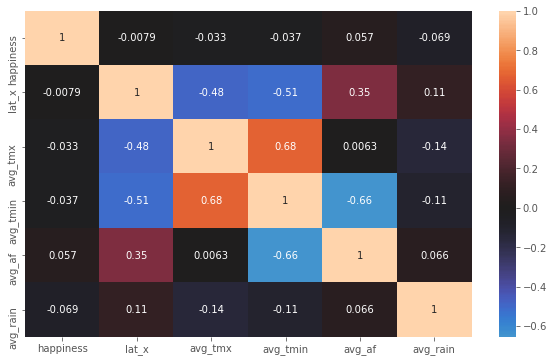

In [75]:
corrmat= new_df[['happiness', 'lat_x',  
        'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain',
       ]].corr()
plt.figure(figsize=(10,6))  
sns.heatmap(corrmat,annot=True,  center=0);

### linear modeling and tune models

Tied a few times with different combinations of features, this is the only one that returns a positive R square score.

In [76]:
y = new_df['happiness']
X = new_df[['avg_af', 'avg_rain',]]

In [77]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [78]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[-3.75706328e-01 -3.07777178e-02 -7.79262312e-01 -2.17826750e-02
 -1.08638387e-01  2.42749945e-04  9.41363690e-03 -4.80079025e-01
 -3.91227291e-02  3.60841547e-02]
-0.17896286322973892


#### LinerRegression is not working very well. Trying Ridge and Lasso to see if any difference could be made.

In [79]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

51.11433483440168


In [80]:
optimal_ridge.score(Xs,y)

0.008333485668272078

In [81]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(cv=10, n_alphas=500, verbose=1)

In [82]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[-3.75646875e-01 -3.07475941e-02 -7.79425722e-01 -2.17955304e-02
 -1.08579590e-01  2.51386535e-04  9.41037984e-03 -4.80058440e-01
 -3.91281113e-02  3.60013464e-02]
-0.17897187500419376


In [83]:
lasso.fit(Xs,y)
print(lasso.score(Xs,y))

0.008534041732398912


In [84]:
lasso.fit(Xs, y)
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
1,avg_rain,-0.017324,0.017324
0,avg_af,0.014643,0.014643


In [85]:
print('Percent variables zeroed out:', np.sum((np.abs(lasso.coef_) < 0.2))/float(X.shape[0]))

Percent variables zeroed out: 0.006622516556291391


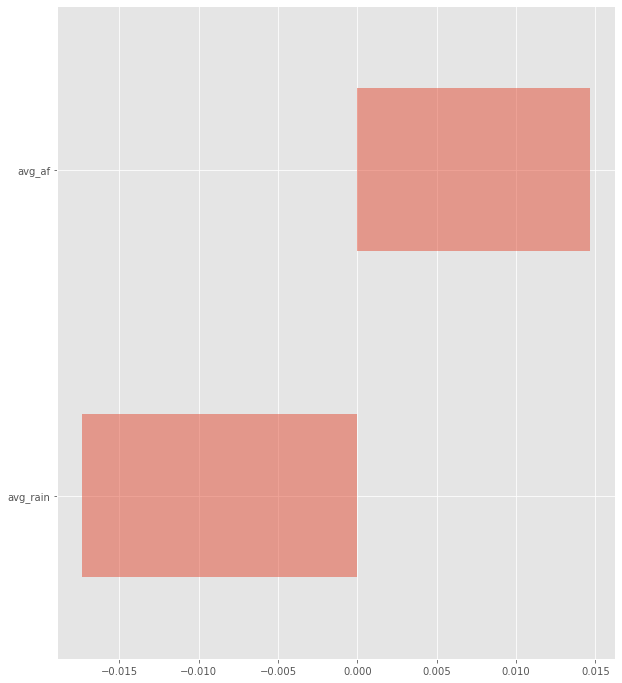

In [86]:
fig, ax = plt.subplots(figsize=(10,12))
lasso_coefs.coef[:20].plot(kind='barh',ax=ax,alpha=0.5)
ax.set_yticklabels(lasso_coefs.variable[:20].values)
plt.show()

#### Findings:

- Both Ridge and Lasso worked better than LinearRegression as they all give a positive R score. 
- And from the coefficients, at least, we can see some negative relations between 'avg_rain' and happiness. This make sense.
- The reason that LinearRegression didn't work well is because the poor data engineering. I could reorganize data and potentially get a better results than this.

# PART 4

4.2 Perform LinearRegression and Clustering on happy_cities data

In [93]:
happy_cities.head()

,city,happiness,lat
0,South Hams,7.65,50.372
1,Weymouth and Portland,7.61,50.596
2,Teignbridge,7.88,50.613
3,West Devon,7.29,50.652
4,Purbeck,7.74,50.685


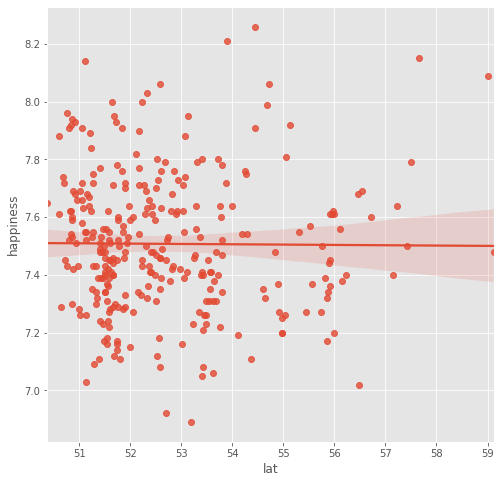

In [161]:
fig,ax=plt.subplots(figsize=(8,8))
ax = sns.regplot(x='lat', y='happiness', data=happy_cities)

In [113]:
X = pd.DataFrame(happy_cities['lat'])
y = happy_cities.happiness

In [114]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [115]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[-0.44916953 -0.01860436 -1.05695796 -0.04276447 -0.06050396 -0.00437077
 -0.00151417 -0.46386921 -0.05656245 -0.09857322]
-0.22528901049072866


#### Findings:
- As latitude goes up, happiness drops a little, this suggesting that people who live in the south, generally speaking, are slightly happier than those living in the north. 

#### Tune model.
Compare to the eps of the weather data, the eps of happy_cities are more sensitive. 

In [140]:
dbscan = DBSCAN(eps=0.1, min_samples=3)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  2  2 -1 -1 -1  3  3  3 -1 -1] 

types of clusters: 4


In [157]:
dbscan = DBSCAN(eps=0.07, min_samples=2)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2  2  2  2  3  3  3
  3  3  3  3  3  3 -1  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  7  7  7 -1  8  8  9  9 -1 10 10] 

types of clusters: 11


In [163]:
happy_cities_copy = happy_cities
happy_cities_copy['labels'] = labels
happy_cities_copy.labels.value_counts()

 0     248
 5      14
 3       9
 1       8
 2       4
-1       4
 7       3
 6       3
 4       3
 10      2
 9       2
 8       2
Name: labels, dtype: int64

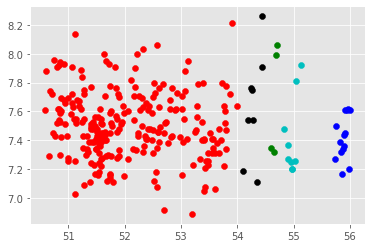

In [177]:
plt.scatter(happy_cities_copy[happy_cities_copy['labels']==0].lat,happy_cities_copy[happy_cities_copy['labels']==0].happiness,c='r' )
plt.scatter(happy_cities_copy[happy_cities_copy['labels']==5].lat,happy_cities_copy[happy_cities_copy['labels']==5].happiness, c='b' )
plt.scatter(happy_cities_copy[happy_cities_copy['labels']==3].lat,happy_cities_copy[happy_cities_copy['labels']==3].happiness, c='c' )
plt.scatter(happy_cities_copy[happy_cities_copy['labels']==1].lat,happy_cities_copy[happy_cities_copy['labels']==1].happiness, c='k' )
plt.scatter(happy_cities_copy[happy_cities_copy['labels']==2].lat,happy_cities_copy[happy_cities_copy['labels']==2].happiness, c='g' )
plt.show()